In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [5]:
wiki_movies = pd.read_csv('wiki_movie_plots_deduped.csv', delimiter=',')
wiki_movies.dataframeName = 'wiki_movie_plots_deduped.csv'
Rows, Cols = wiki_movies.shape
print(f' {Rows} rows, {Cols} columns')

 34886 rows, 8 columns


In [6]:
wiki_movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [7]:
null_val = wiki_movies.isnull().sum() #check for null values
dupe_val = wiki_movies.duplicated().sum() # check for duplicate rows
wiki_movies['Count']=1

print(null_val)
print(f'{dupe_val} dupe values')

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64
0 dupe values


In [8]:
wiki_movies_cleaned = wiki_movies.dropna() #drop all null rows

In [9]:
wiki_movies_cleaned[['Genre','Count']].groupby(['Genre'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)

,Genre,Count
839,drama,5841
2117,unknown,5400
554,comedy,4347
1357,horror,1124
7,action,1087
2063,thriller,955
1682,romance,918
2156,western,864
731,crime,565
285,adventure,524


In [10]:
wiki_movies_cleaned = wiki_movies_cleaned[wiki_movies_cleaned.Genre != 'unknown']


In [11]:
wiki_movies_cleaned[['Genre','Count']].groupby(['Genre'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)

,Genre,Count
839,drama,5841
554,comedy,4347
1357,horror,1124
7,action,1087
2063,thriller,955
1682,romance,918
2155,western,864
731,crime,565
285,adventure,524
1514,musical,465


In [12]:
top_genres = ['drama','comedy', 'horror','action', 'thriller', 'romance', 'western', 'crime','adventure','musical']
selected_movies = wiki_movies_cleaned[wiki_movies_cleaned['Genre'].isin(top_genres)]
selected_movies[['Genre','Count']].groupby(['Genre'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)

,Genre,Count
4,drama,5841
2,comedy,4347
5,horror,1124
0,action,1087
8,thriller,955
7,romance,918
9,western,864
3,crime,565
1,adventure,524
6,musical,465


In [13]:
def format_plot(plot):
    plot = plot.lower()
    plot = re.sub(r"what's", "what is ", plot)
    plot = re.sub(r"\'s", " ", plot)
    plot = re.sub(r"\'ve", " have ", plot)
    plot = re.sub(r"can't", "can not ", plot)
    plot = re.sub(r"n't", " not ", plot)
    plot = re.sub(r"i'm", "i am ", plot)
    plot = re.sub(r"\'re", " are ", plot)
    plot = re.sub(r"\'d", " would ", plot)
    plot = re.sub(r"\'ll", " will ", plot)
    plot = re.sub(r"\'scuse", " excuse ", plot)
    plot = plot.strip(' ')
    return plot

In [14]:
selected_movies.reset_index(drop=True, inplace=True)
selected_movies['Plot']

0        Before heading out to a baseball game at a nea...
1        The plot is that of a black woman going to the...
2        On a beautiful summer day a father and mother ...
3        A thug accosts a girl as she leaves her workpl...
4        A young couple decides to elope after being ca...
                               ...                        
16685    Hasan is a twelve-year-old boy living with his...
16686    Through the night, three cars carry a small gr...
16687    The film opens with a Senegalese boy named Kha...
16688    Two musicians, Salih and Gürkan, described the...
16689    Zafer, a sailor living with his mother Döndü i...
Name: Plot, Length: 16690, dtype: object

In [15]:
selected_movies['FormattedPlot'] = selected_movies['Plot'].apply(format_plot)

C:\Users\bigbe\AppData\Local\Temp/ipykernel_19284/884633232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_movies['FormattedPlot'] = selected_movies['Plot'].apply(format_plot)


In [16]:
selected_movies['FormattedPlot']

0        before heading out to a baseball game at a nea...
1        the plot is that of a black woman going to the...
2        on a beautiful summer day a father and mother ...
3        a thug accosts a girl as she leaves her workpl...
4        a young couple decides to elope after being ca...
                               ...                        
16685    hasan is a twelve-year-old boy living with his...
16686    through the night, three cars carry a small gr...
16687    the film opens with a senegalese boy named kha...
16688    two musicians, salih and gürkan, described the...
16689    zafer, a sailor living with his mother döndü i...
Name: FormattedPlot, Length: 16690, dtype: object

In [17]:
def combineAllPlots(genre):
    plotValues = selected_movies.loc[selected_movies['Genre'] == genre]['FormattedPlot'].values
    plotWords =  " ".join(plotValues)
    return plotWords

In [18]:
genre_plots = {}
for i in top_genres:
    genre_plots["{0}".format(i)] = combineAllPlots(i)

In [19]:
def generateWordcloud(plot):
    wordcloud = WordCloud().generate(str(plot))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

drama


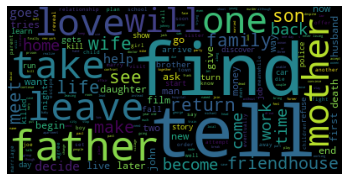

comedy


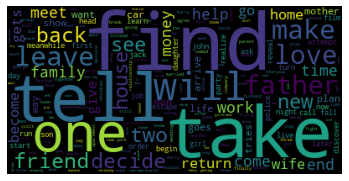

horror


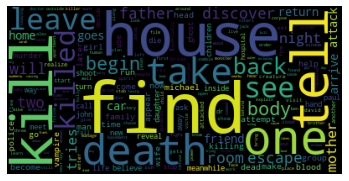

action


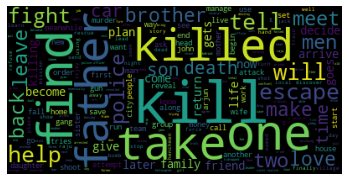

thriller


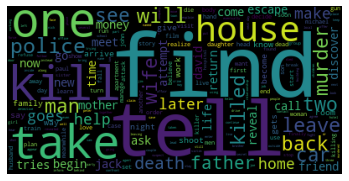

romance


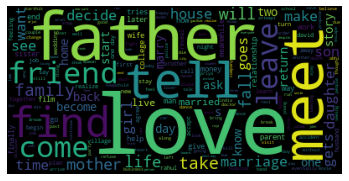

western


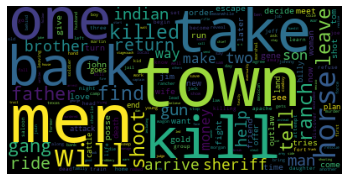

crime


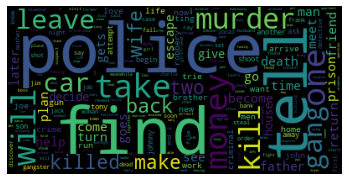

adventure


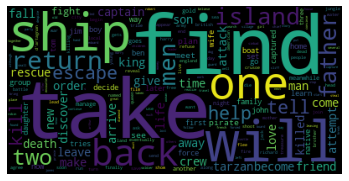

musical


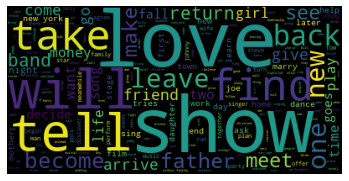

In [20]:
for genre in genre_plots:
    print(genre)
    generateWordcloud(genre_plots[genre])

In [50]:
X = selected_movies['FormattedPlot'] # split the dataframes into X & Y columns
Y = selected_movies['Genre']

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
CV = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)
X_CV = CV.fit_transform(X)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_CV, Y, test_size=0.2, random_state=0)

In [67]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [65]:
LR=LogisticRegression(max_iter=5000)
LR.fit(X_train, y_train)
pred = LR.predict(X_test)
cm_array = multilabel_confusion_matrix(y_test, pred)

In [70]:
print(pred)
print(y_test)

['comedy' 'drama' 'drama' ... 'thriller' 'drama' 'drama']
7818       comedy
6178        drama
791         drama
15025       drama
4608       comedy
           ...   
5584        drama
16499       drama
8226       action
13043    thriller
8088        drama
Name: Genre, Length: 3338, dtype: object


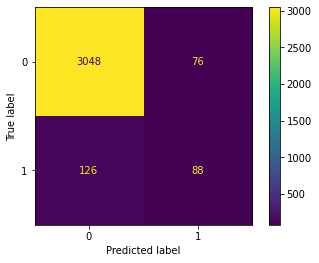

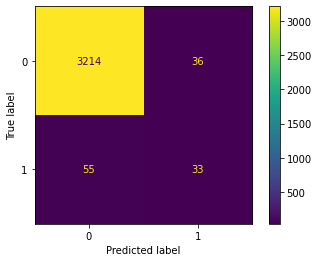

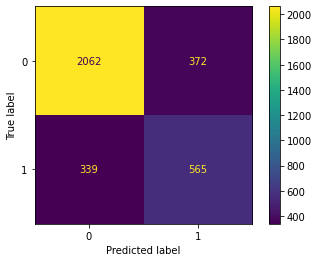

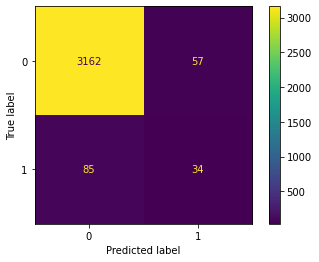

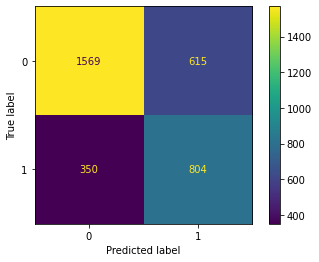

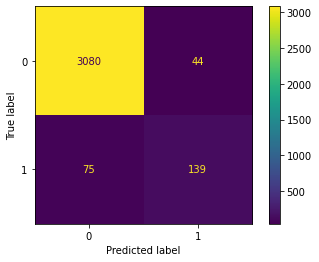

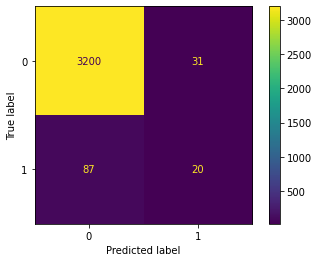

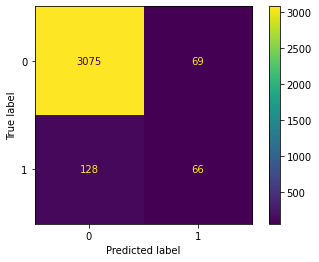

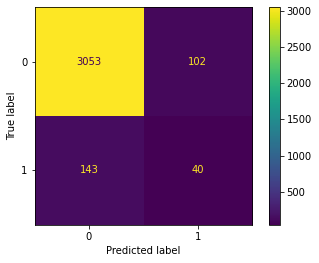

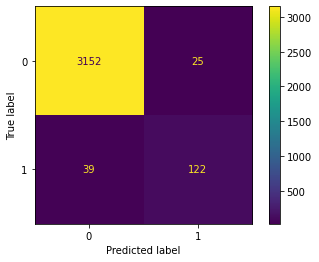

In [68]:
for cm in cm_array:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()